## Bond Data Download

In [100]:
import pickle
from pykrx.website.krx.krxio import KrxWebIo
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data_path = 'simulation_data'

class Bond_YTM(KrxWebIo):
    @property
    def bld(self):
        return 'dbms/MDC/STAT/standard/MDCSTAT11402'
    def fetch(self, strtDd: str, endDd: str, bndKindTpCd: str):
        result = self.read(locale="ko_KR", inqTpCd='E', bndKindTpCd=bndKindTpCd, strtDd=strtDd, endDd=endDd)
        return pd.DataFrame(result['output'])

In [129]:
# 채권 데이터를 저장할 Frame 생성
start_date = '2016-01-02'
end_date = '2025-03-20'
with open(f"{data_path}/KS200_MASK.pkl", "rb") as f:
    frame = pickle.load(f) # 열이 시계열
# start_date와 end_date 사이의 데이터만 추출
frame = frame.loc[:, start_date:end_date]

In [130]:
# bndKindTpCd
# 국고채 10년: 3013
# cd 91일: 3013
# 회사채 AA- 무보증 3년: 3009
# 회사채 BB- 무보증 3년: 3010
def fast_fill_frame(frame: pd.DataFrame, bond_df: pd.DataFrame) -> pd.DataFrame:
    # 1) 복사 & numeric 변환
    frame_ = frame.copy().apply(pd.to_numeric, errors='coerce')
    
    # 2) gov10_df의 'LST_ORD_BAS_YD' 시리즈를 frame 컬럼 순서에 맞게 재색인
    #    (컬럼이 완전히 일치한다면 reindex는 생략 가능)
    series = bond_df.loc['LST_ORD_BAS_YD'].reindex(frame_.columns)
    
    # 3) 벡터 브로드캐스트로 한 번에 모든 행을 채우기
    #    DataFrame[:] = 2D numpy array 형태로 할당하면 모든 셀에 일괄 적용됩니다.
    frame_.iloc[:, :] = np.tile(series.values, (len(frame_), 1))
    
    return frame_

def fetch_bond_df(start_date, end_date, bond_type, frame):
    # 1) 원시 데이터 fetch & 날짜 포맷 정리
    raw = Bond_YTM().fetch(
        strtDd=start_date.replace('-', ''), 
        endDd=end_date.replace('-', ''), 
        bndKindTpCd=bond_type
    ).sort_values(by='DISCLS_DD')
    
    raw['DISCLS_DD'] = raw['DISCLS_DD'].str.replace('/', '-')
    raw = raw.set_index('DISCLS_DD')
    
    # 2) 모든 컬럼을 강제 numeric → float (문자열은 NaN 처리)
    raw = raw.apply(pd.to_numeric, errors='coerce')
    
    # 3) 전치하여 날짜가 컬럼이 되도록
    X = raw.transpose()
    
    # 4) target 시계열 D로 리인덱스 & 정렬
    D = frame.columns
    X = X.sort_index(axis=1)
    X = X.reindex(columns=D)
    
    # 5) 보간 및 끝단 채우기
    X = (
        X
        .interpolate(method="linear", axis=1)  # 중간 NaN 선형 보간
        .ffill(axis=1)                         # 앞단 NaN forward-fill
        .bfill(axis=1)                         # 뒷단 NaN backward-fill
    )
    
    # 6) 원본 범위 밖 컬럼(drop)
    orig_dates = raw.index  # 실제 있는 날짜들
    min_date, max_date = orig_dates.min(), orig_dates.max()
    keep = [d for d in D if min_date <= d <= max_date]
    X_final = X.loc[:, keep]
    
    return fast_fill_frame(frame, X_final)

In [106]:
bond_data_dict={
    'gov10': '3013', # 국고채 10년 금리
    'gov3': '3000', # 국고채 3년 금리
    'rf': '4000', # CD 91일 금리
    'corp_aa': '3009', # 회사채 AA- 무보증 3년 금리
    'corp_bb': '3010', # 회사채 BB- 무보증 3년 금리
}
for bond_type, bond_code in bond_data_dict.items():
    print(f"Fetching {bond_type} data...")
    bond_df = fetch_bond_df(start_date, end_date, bond_code, frame)
    print(f"Saving {bond_type} data...")
    with open(f"{data_path}/{bond_type}_bond.pkl", "wb") as f:
        pickle.dump(bond_df, f)
    print(f"{bond_type} data saved.")

Fetching gov10 data...
Saving gov10 data...
gov10 data saved.
Fetching gov3 data...
Saving gov3 data...
gov3 data saved.
Fetching rf data...
Saving rf data...
rf data saved.
Fetching corp_aa data...
Saving corp_aa data...
corp_aa data saved.
Fetching corp_bb data...
Saving corp_bb data...
corp_bb data saved.


## Data Load and Portfolio Construction

In [135]:
start_date = '2016-03-30'
end_date = '2025-03-20'
with open(f"{data_path}/KS200_MASK.pkl", 'rb') as f:
    mask_df:pd.DataFrame = pickle.load(f).ffill(axis=1)
    mask_df = mask_df.loc[:, start_date:end_date]
with open(f"{data_path}/Return.pkl", 'rb') as f:
    returns_df = pickle.load(f).ffill(axis=1)
    returns_df = returns_df.loc[:, start_date:end_date]
with open(f"{data_path}/MarketCap.pkl", 'rb') as f:
    mc_df = pickle.load(f).ffill(axis=1)
    mc_df = mc_df.loc[:, start_date:end_date]
with open(f"{data_path}/ifrs-full_Equity.pkl", 'rb') as f:
    be_df = pickle.load(f).ffill(axis=1)
    be_df = be_df.loc[:, start_date:end_date]
with open(f"{data_path}/KOSPI_Close.pkl", 'rb') as f:
    kospi_close_df = pickle.load(f).ffill(axis=1)
    kospi_close_df = kospi_close_df.loc[:, start_date:end_date]
with open(f"{data_path}/rf_bond.pkl", 'rb') as f:
    rf_df = pickle.load(f).ffill(axis=1)
    rf_df = rf_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_aa_bond.pkl", 'rb') as f:
    corp_aa_df = pickle.load(f).ffill(axis=1)
    corp_aa_df = corp_aa_df.loc[:, start_date:end_date]
with open(f"{data_path}/corp_bb_bond.pkl", 'rb') as f:
    corp_bb_df = pickle.load(f).ffill(axis=1)
    corp_bb_df = corp_bb_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov10_bond.pkl", 'rb') as f:
    gov10_df = pickle.load(f).ffill(axis=1)
    gov10_df = gov10_df.loc[:, start_date:end_date]
with open(f"{data_path}/gov3_bond.pkl", 'rb') as f:
    gov3_df = pickle.load(f).ffill(axis=1)
    gov3_df = gov3_df.loc[:, start_date:end_date]
corp_df = (corp_aa_df + corp_bb_df) / 2

In [136]:
import statsmodels.api as sm

R     = returns_df
MC    = mc_df
BE    = be_df 
RF = rf_df
GOV10   = gov10_df
GOV3 = gov3_df
CORP  = corp_df
MKT   = kospi_close_df.pct_change(axis=1)
mask  = mask_df.astype(bool)

dates = R.columns
tickers = R.index

## Regressions for 5 models

In [142]:
import statsmodels.api as sm


# ── 1) 일별 리밸런싱으로 25개 포트폴리오(S1B1…S5B5) 수익 계산 ──
port_rets = {f"S{i}B{j}":[] for i in range(1,6) for j in range(1,6)}

for dt in dates:
    members = mask[dt][mask[dt]].index
    if members.empty: 
        continue

    # size quintile breakpoints
    me = MC.loc[members, dt].dropna()
    sz_br = me.quantile([0.2,0.4,0.6,0.8]).values

    # BE/ME quintile breakpoints
    bm = (BE.loc[members, dt] / MC.loc[members, dt]).dropna()
    bm_br = bm.quantile([0.2,0.4,0.6,0.8]).values

    # 각 포트폴리오
    for i in range(1,6):
        size_idx = me[
            (me >  (sz_br[i-2] if i>1 else -np.inf)) &
            (me <= (sz_br[i-1] if i<5 else  np.inf))
        ].index
        for j in range(1,6):
            bm_idx = bm[
              (bm >  (bm_br[j-2] if j>1 else -np.inf)) &
              (bm <= (bm_br[j-1] if j<5 else  np.inf))
            ].index

            idx = size_idx.intersection(bm_idx)
            name = f"S{i}B{j}"
            if idx.empty:
                ret = np.nan
            else:
                w = MC.loc[idx, dt]
                w = w / w.sum()
                ret = (R.loc[idx, dt] * w).sum()
            port_rets[name].append((dt, ret))

# DataFrame으로 변환
port_df = pd.DataFrame({
    name: pd.Series(dict(port_rets[name]))
    for name in port_rets
}).sort_index(axis=1)

# ── 2) SMB, HML 계산 ──
# SMB: size quintile 1 평균 – quintile 5 평균
SMB = (port_df[[f"S1B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S2B{j}" for j in range(1,6)]].mean(axis=1)) \
        - (port_df[[f"S5B{j}" for j in range(1,6)]].mean(axis=1) + port_df[[f"S4B{j}" for j in range(1,6)]].mean(axis=1)) 

# HML: BE quintile 5 평균 – quintile 1 평균
HML = (port_df[[f"S{i}B5" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B4" for i in range(1,6)]].mean(axis=1))\
     - (port_df[[f"S{i}B1" for i in range(1,6)]].mean(axis=1) + port_df[[f"S{i}B2" for i in range(1,6)]].mean(axis=1))

# ── 3) 팩터 DataFrame 생성 ──
factors = pd.DataFrame({
    'MKT_RF': MKT.iloc[0] - RF.iloc[0],
    'SMB':     SMB,
    'HML':     HML,
    'TERM':    GOV10.iloc[0]  - RF.iloc[0],
    'DEF':     CORP.iloc[0] - GOV3.iloc[0],
    'RF':      RF.iloc[0]
}, index=dates).dropna()

# ── 4) 5가지 모형 정의 ──
models = {
    'i_TERM_DEF'      : ['TERM','DEF'],
    'ii_MKT_RF'       : ['MKT_RF'],
    'iii_SMB_HML'     : ['SMB','HML'],
    'iv_MKT_SMB_HML'  : ['MKT_RF','SMB','HML'],
    'v_all_5_factors' : ['MKT_RF','SMB','HML','TERM','DEF'],
}

# ── 5) 25개 포트 × 5 모형 회귀 ──
outputs = {}
for mname, facs in models.items():
    recs = []
    for name in port_df.columns:
        y = (port_df[name] - factors['RF']).dropna()
        common = y.index.intersection(factors.index)
        y = y.loc[common]
        X = factors[facs].loc[common]
        Xc = sm.add_constant(X)

        res = sm.OLS(y, Xc).fit()
        rec = {'Portfolio':name}
        for coef in ['const']+facs:
            rec[f"b_{coef}"] = res.params.get(coef, np.nan)
            rec[f"t_{coef}"] = res.tvalues.get(coef, np.nan)
        rec['R2']   = res.rsquared
        rec['s(e)'] = np.sqrt(res.mse_resid)
        recs.append(rec)

    dfm = pd.DataFrame(recs).set_index('Portfolio')
    tuples = [(int(p[1]), int(p[3])) for p in dfm.index]  # ("S{i}B{j}")
    dfm.index = pd.MultiIndex.from_tuples(tuples, names=['SizeQ','BEQ'])
    outputs[mname] = dfm

# ── 6) 결과 출력 ──
for mname, dfm in outputs.items():
    print(f"\n=== Model {mname} ===")

    # b coefficients
    bc = dfm[[c for c in dfm if c.startswith('b_')]].rename(columns=lambda x: x[2:])
    print("\n-- b coefficients --")
    print(bc.unstack(level='BEQ'))

    # t(b)
    tc = dfm[[c for c in dfm if c.startswith('t_')]].rename(columns=lambda x: x[2:])
    print("\n-- t(b) statistics --")
    print(tc.unstack(level='BEQ'))

    # R²
    print("\n-- R² --")
    print(dfm['R2'].unstack(level='BEQ'))

    # s(e)
    print("\n-- s(e) --")
    print(dfm['s(e)'].unstack(level='BEQ'))



=== Model i_TERM_DEF ===

-- b coefficients --
          const                                              TERM            \
BEQ           1         2         3         4         5         1         2   
SizeQ                                                                         
1     -2.215418 -2.868779 -2.751721 -2.597745 -2.960058  1.214206  1.259107   
2     -2.486228 -2.373562 -2.783153 -2.698326 -2.752614  1.216152  1.284778   
3     -2.905888 -2.482745 -2.702714 -3.121325 -2.728279  1.317147  1.196127   
4     -2.797298 -2.386887 -2.707620 -2.396993 -2.752694  1.123919  1.220528   
5     -2.435618 -2.364438 -2.786187 -2.856690 -2.489997  1.184405  1.171047   

                                          DEF                                \
BEQ           3         4         5         1         2         3         4   
SizeQ                                                                         
1      1.213241  1.187942  1.223841 -0.104808  0.061610  0.033875  0.004600   
2  

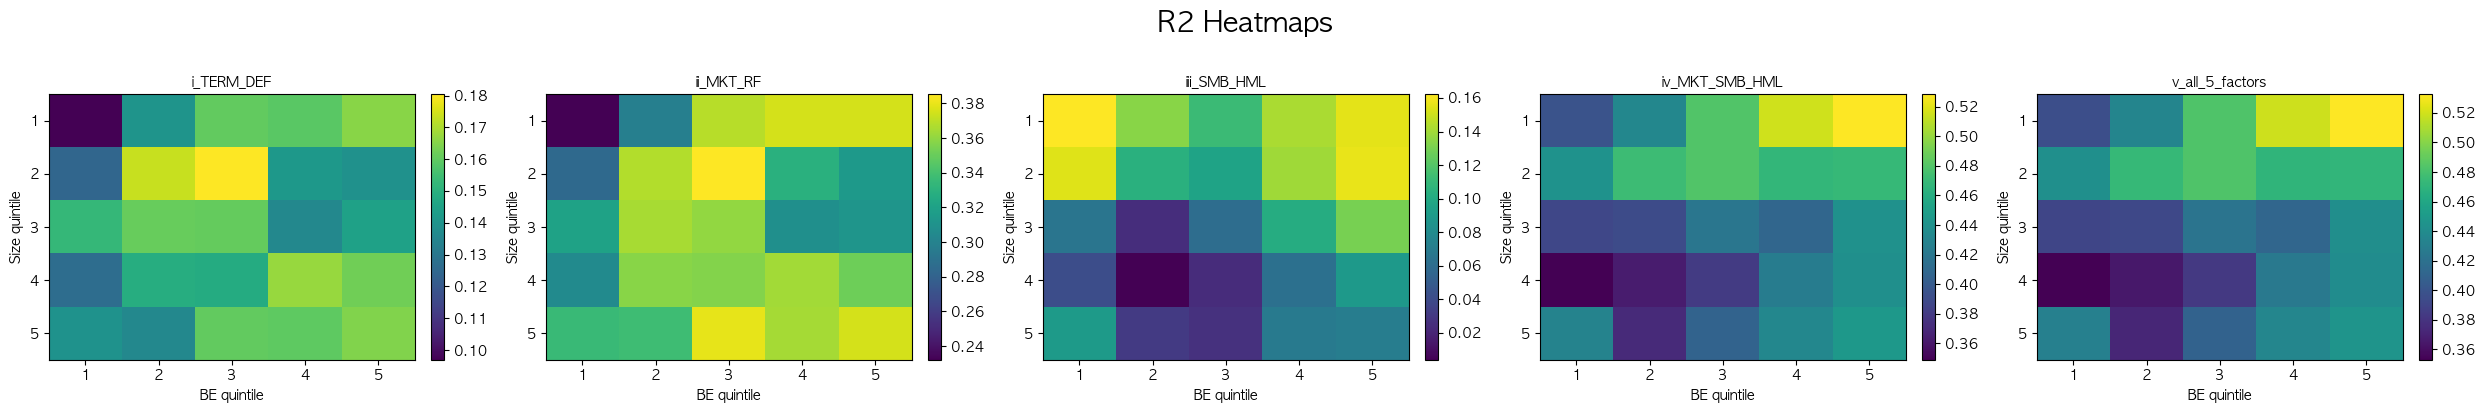

In [143]:
import matplotlib.pyplot as plt

models = list(outputs.keys())

fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))
for ax, m in zip(axes, models):
    dfm = outputs[m]
    # BEQ를 열로, SizeQ를 행으로 한 pivot table
    mat = dfm['R2'].unstack(level='BEQ').sort_index()
    im = ax.imshow(mat, aspect='auto')
    ax.set_title(m, fontsize=10)
    ax.set_xlabel('BE quintile')
    ax.set_ylabel('Size quintile')
    ax.set_xticks(range(5))
    ax.set_xticklabels(mat.columns)
    ax.set_yticks(range(5))
    ax.set_yticklabels(mat.index)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.suptitle('R2 Heatmaps', y=1.02, fontsize=20)
plt.tight_layout()
plt.show()


## GRS TEST for 5 Regression Models